# Air Quality Forecasting

**Author:** Kanisa Rebecca Majok Thiak

**Purpose:** Clean, well-documented notebook with reproducible preprocessing, model training (LSTM-based),
structured experiment logging (CSV), and automatic plot saving for report inclusion.

**Notes:** This notebook adds: seed setting, feature engineering, sequence generation functions, an improved model
(Conv1D + Stacked LSTM + Attention), callbacks, RMSE logging to CSV, and figure exports.


## 1 — Setup

Install / import libraries, set random seeds for reproducibility, and define helper utilities.

In [2]:


# Setup: imports, seeds, and helper functions
import os
import random
import json
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, backend as K
import gc

# nbformat is optional — guard import so notebook runs when package missing
try:
    import nbformat
except Exception:
    nbformat = None
    import warnings
    warnings.warn("nbformat not available. Notebook I/O features disabled. Install with: pip install nbformat", UserWarning)

# Reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.19.0


C:\Users\HP\AppData\Local\Temp\ipykernel_24012\1575331157.py:20: UserWarning: nbformat not available. Notebook I/O features disabled. Install with: pip install nbformat
  warnings.warn("nbformat not available. Notebook I/O features disabled. Install with: pip install nbformat", UserWarning)


## 2 — Load data

Load `train.csv`, `test.csv`, and `sample_submission.csv`. If files are in a different path, update the paths accordingly.

In [3]:

# --- Robust data loader (replace previous /mnt paths) ---
from pathlib import Path

# candidate locations to search for the Datasets folder
CANDIDATE_DIRS = [
    Path.cwd() / "Datasets",
    Path("Datasets"),
    Path("..") / "Datasets",
    Path.cwd().parent / "Datasets",
    Path.home() / "Datasets",
    Path(r"C:\Users\HP\Datasets"),
]

DATA_DIR = None
for d in CANDIDATE_DIRS:
    d = d.resolve()
    # accept folder if it contains at least one expected file
    if (d / "train.csv").exists() or (d / "test.csv").exists() or (d / "sample_submission.csv").exists():
        DATA_DIR = d
        break

if DATA_DIR is None:
    # fallback: prefer repo-relative ../Datasets (keeps previous behavior) but warn
    DATA_DIR = Path("../Datasets").resolve()
    print("Warning: no dataset files detected in common locations. Using", DATA_DIR)
else:
    print("DATA_DIR resolved to:", DATA_DIR)

TRAIN_PATH = DATA_DIR / "train.csv"
TEST_PATH = DATA_DIR / "test.csv"
SAMPLE_SUB_PATH = DATA_DIR / "sample_submission.csv"

# Diagnostic info
print("Train exists:", TRAIN_PATH.exists(), "->", TRAIN_PATH)
print("Test exists: ", TEST_PATH.exists(), "->", TEST_PATH)
print("Sample sub exists:", SAMPLE_SUB_PATH.exists(), "->", SAMPLE_SUB_PATH)

# Load if present, otherwise create empty DataFrames
train = pd.read_csv(TRAIN_PATH, parse_dates=['datetime']) if TRAIN_PATH.exists() else pd.DataFrame()
test = pd.read_csv(TEST_PATH, parse_dates=['datetime']) if TEST_PATH.exists() else pd.DataFrame()
sample_sub = pd.read_csv(SAMPLE_SUB_PATH) if SAMPLE_SUB_PATH.exists() else pd.DataFrame()

# quick summary
print("Train rows:", len(train))
print("Test rows: ", len(test))
if train.empty:
    print("Train is empty. Place train.csv in", DATA_DIR, "or update DATA_DIR.")

DATA_DIR resolved to: C:\Users\HP\Time-Series-Forecasting\Datasets
Train exists: True -> C:\Users\HP\Time-Series-Forecasting\Datasets\train.csv
Test exists:  True -> C:\Users\HP\Time-Series-Forecasting\Datasets\test.csv
Sample sub exists: True -> C:\Users\HP\Time-Series-Forecasting\Datasets\sample_submission.csv
Train rows: 30676
Test rows:  13148


## 3 — Exploratory Data Analysis (brief)

Generate quick summary stats and a time-series plot for PM2.5. These plots will be saved for the report.

,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
count,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676,30676.000000,30676.000000,30676.000000,28755.000000
mean,15338.500000,-0.029431,-0.062712,0.013612,0.030542,0.016992,0.011253,2011-10-02 01:30:00,0.016193,0.005833,-0.025008,100.793427
min,1.000000,-2.135153,-2.578070,-2.380821,-0.468688,-0.069353,-0.137667,2010-01-01 00:00:00,-0.690542,-0.732019,-0.522096,0.000000
25%,7669.750000,-0.888034,-0.938521,-0.822670,-0.441894,-0.069353,-0.137667,2010-11-16 12:45:00,-0.690542,-0.732019,-0.522096,29.000000
50%,15338.500000,-0.056622,0.045209,-0.043595,-0.352512,-0.069353,-0.137667,2011-10-02 01:30:00,-0.690542,-0.732019,-0.522096,75.000000
75%,23007.250000,0.913358,0.864984,0.832865,0.005216,-0.069353,-0.137667,2012-08-16 14:15:00,1.448138,1.366085,-0.522096,142.000000
max,30676.000000,1.814055,2.340578,2.877939,11.231956,35.439859,25.288745,2013-07-02 03:00:00,1.448138,1.366085,1.915355,994.000000
std,8855.542765,0.994087,1.015193,1.008991,1.018337,1.087278,1.063811,NaN,1.006001,1.001847,0.982122,93.144433


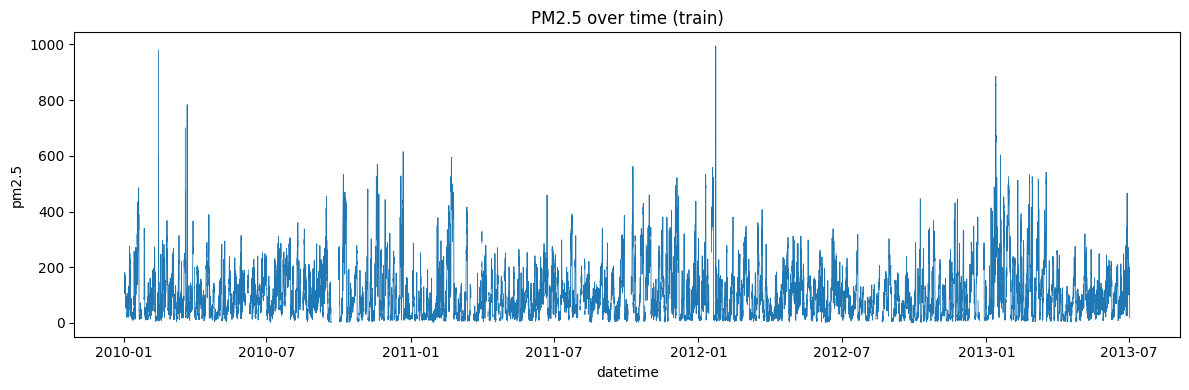

In [4]:

# Quick EDA (if train is loaded)
os.makedirs('figures', exist_ok=True)

if not train.empty:
    display(train.describe())

    if 'pm2.5' in train.columns:
        plt.figure(figsize=(12,4))
        plt.plot(train['datetime'], train['pm2.5'], linewidth=0.6)
        plt.title('PM2.5 over time (train)')
        plt.xlabel('datetime'); plt.ylabel('pm2.5')
        plt.tight_layout()
        plt.savefig('figures/pm25_timeseries.png', dpi=150)
        plt.show()
    else:
        print('Column pm2.5 not found in train.')
else:
    print('Train is empty - cannot run EDA.')


## 4 — Preprocessing & Feature Engineering

Steps:
- Resample/reindex to hourly if needed
- Handle missing values (ffill/interpolate)
- Convert wind direction to sin/cos
- Create time features and lag / rolling features
- Scale features (StandardScaler)

All steps are explained in the comments below.

In [5]:

from sklearn.preprocessing import StandardScaler

def preprocess_df(df):
    # Make a copy
    df = df.copy()
    # Ensure datetime index
    if 'datetime' in df.columns:
        df = df.set_index('datetime').sort_index()
    # Resample hourly (if irregular)
    df = df.resample('H').mean()
    # Forward fill small gaps, then interpolate
    df = df.ffill(limit=3).interpolate(limit_direction='both')
    # Time features
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    # Cyclic encode hour
    df['hour_sin'] = np.sin(2*np.pi*df['hour']/24)
    df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)
    # Example: wind direction conversion if exists
    if 'wind_direction' in df.columns:
        wd = df['wind_direction'].fillna(0).values
        df['wd_sin'] = np.sin(np.deg2rad(wd))
        df['wd_cos'] = np.cos(np.deg2rad(wd))
    return df

# Apply to train and test
if not train.empty:
    train_p = preprocess_df(train)
    test_p = preprocess_df(test) if not test.empty else pd.DataFrame()
    print('Preprocessed train shape:', train_p.shape)
else:
    train_p = pd.DataFrame()
    test_p = pd.DataFrame()


Preprocessed train shape: (30676, 16)


C:\Users\HP\AppData\Local\Temp\ipykernel_24012\3359027523.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('H').mean()
C:\Users\HP\AppData\Local\Temp\ipykernel_24012\3359027523.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('H').mean()


### 4.1 — Lag and rolling features

Create common lag features and rolling means which often improve RNN performance on air-quality tasks.

In [6]:

def add_lag_features(df, target_col='pm2.5', lags=[1,3,6,12,24]):
    df = df.copy()
    for l in lags:
        df[f'{target_col}_lag_{l}'] = df[target_col].shift(l)
    # Rolling windows
    df[f'{target_col}_roll_mean_3'] = df[target_col].rolling(window=3).mean()
    df[f'{target_col}_roll_mean_24'] = df[target_col].rolling(window=24).mean()
    df = df.ffill().bfill()
    return df

if not train_p.empty and 'pm2.5' in train_p.columns:
    train_p = add_lag_features(train_p, 'pm2.5')
    print('Added lag features. Columns now:', train_p.columns.tolist()[:20])


Added lag features. Columns now: ['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'pm2.5', 'hour', 'dayofweek', 'month', 'hour_sin', 'hour_cos', 'pm2.5_lag_1', 'pm2.5_lag_3', 'pm2.5_lag_6', 'pm2.5_lag_12']


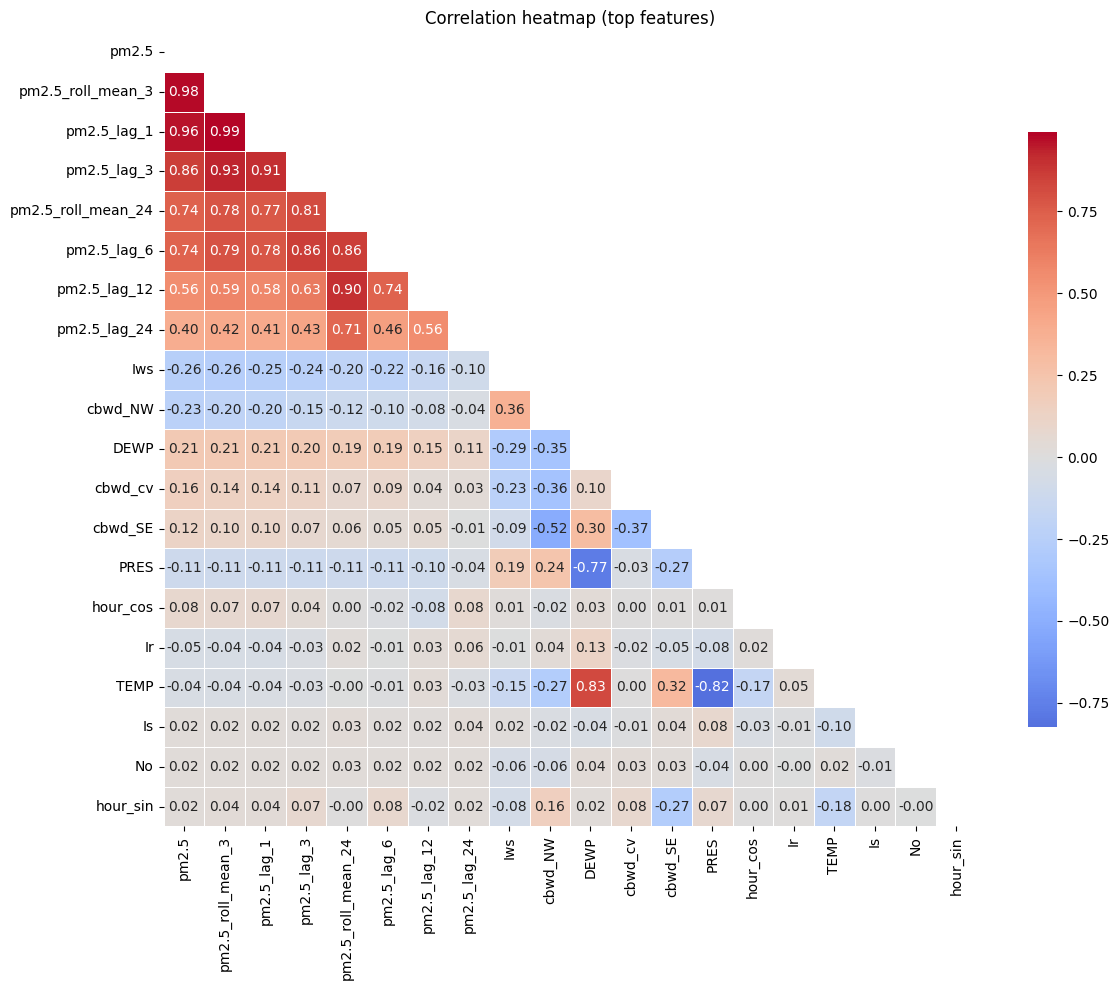

In [7]:

import seaborn as sns
import os

if 'train_p' in globals() and not train_p.empty:
    # numeric columns only
    df_num = train_p.select_dtypes(include=[np.number]).copy()
    target = 'pm2.5'
    # limit to top correlated features (including target) to keep heatmap readable
    if target in df_num.columns:
        corrs = df_num.corr()[target].abs().sort_values(ascending=False)
        top_cols = corrs.index[:20]  # adjust 20 as needed
        df_plot = df_num.loc[:, top_cols]
    else:
        df_plot = df_num

    corr = df_plot.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=(12,10))
    sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', center=0,
                linewidths=0.5, cbar_kws={"shrink": .75})
    plt.title("Correlation heatmap (top features)")
    plt.tight_layout()
    os.makedirs('figures', exist_ok=True)
    plt.savefig('figures/corr_heatmap.png', dpi=150)
    plt.show()
else:
    print("train_p is empty — run the preprocessing cell first.")
#

## 5 — Sequence builder

Convert tabular time-series into supervised sequences for LSTM input. Function below returns (X, y) arrays and scaler for features.

In [8]:

def build_sequences(df, features, target, seq_len=48, step=1, scaler=None, fit_scaler=True):
    # df: pandas DataFrame indexed by datetime and sorted
    # features: list of feature column names used as inputs
    # target: target column name
    arr = df[features + [target]].dropna().values
    X, y = [], []
    for i in range(seq_len, len(arr), step):
        X.append(arr[i-seq_len:i, :len(features)])
        y.append(arr[i, -1])  # target at time t
    X = np.array(X)
    y = np.array(y)
    # scaling features
    n_samples, n_steps, n_feats = X.shape
    X_reshaped = X.reshape(-1, n_feats)
    if scaler is None and fit_scaler:
        scaler = StandardScaler()
        scaler.fit(X_reshaped)
    if scaler is not None:
        X_reshaped = scaler.transform(X_reshaped)
        X = X_reshaped.reshape(n_samples, n_steps, n_feats)
    return X, y, scaler

# Choose features automatically (exclude target)
if not train_p.empty:
    target_col = 'pm2.5'
    features = [c for c in train_p.columns if c!=target_col]
    # keep a reasonable number of features
    features = features[:12]  # limit for speed; tune as needed
    print('Using features:', features)
    SEQ_LEN = 48
    X, y, scaler = build_sequences(train_p, features, target_col, seq_len=SEQ_LEN)
    print('Sequence shapes:', X.shape, y.shape)
else:
    X, y, scaler = np.array([]), np.array([]), None


Using features: ['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'hour', 'dayofweek']
Sequence shapes: (30628, 48, 12) (30628,)


## 6 — Train / Validation Split (time-based)

Use the last portion of the series as validation to avoid leakage. We'll also create a function to run K-fold time-series CV.

In [9]:

def time_split(X, y, val_ratio=0.2):
    n = len(X)
    split = int(n*(1-val_ratio))
    return X[:split], y[:split], X[split:], y[split:]

if X.size:
    X_train, y_train, X_val, y_val = time_split(X, y, val_ratio=0.15)
    print('Train shape:', X_train.shape, y_train.shape)
    print('Val shape:', X_val.shape, y_val.shape)


Train shape: (26033, 48, 12) (26033,)
Val shape: (4595, 48, 12) (4595,)


## 7 — Model architecture

We define a compact yet strong model: Conv1D for local feature extraction, stacked LSTM for temporal patterns, and a simple attention mechanism before the dense head.

In [10]:

def build_model(input_shape, conv_filters=32, lstm_units=128, dropout=0.3):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv1D(conv_filters, kernel_size=3, padding='causal', activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(lstm_units//2, return_sequences=True))(x)
    # Simple attention
    attention = layers.TimeDistributed(layers.Dense(1, activation='tanh'))(x)
    attention = layers.Flatten()(attention)
    attention = layers.Activation('softmax')(attention)
    attention = layers.RepeatVector(x.shape[-1])(attention)
    attention = layers.Permute([2,1])(attention)
    x = layers.Multiply()([x, attention])
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(1, activation='linear')(x)
    model = keras.Model(inp, out)
    return model

# Build model example
if X_train.size:
    model = build_model((X_train.shape[1], X_train.shape[2]), conv_filters=32, lstm_units=128, dropout=0.3)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-4), loss='mse', metrics=[keras.metrics.RootMeanSquaredError()])
    model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 48, 32)    │      1,184 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 48, 32)    │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 48, 256)   │    164,864 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 48, 128)   │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 48, 1)     │        129 │ bidirectional_1[… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 48)        │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 48)        │          0 │ flatten[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 128, 48)   │          0 │ activation[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 48, 128)   │          0 │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 48, 128)   │          0 │ bidirectional_1[… │
│                     │                   │            │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ multiply[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 338,978 (1.29 MB)

 Trainable params: 338,914 (1.29 MB)

 Non-trainable params: 64 (256.00 B)

## 8 — Training loop with callbacks and structured logging

This cell trains the model and saves:
- model weights
- loss curve `figures/loss_curve.png`
- fold RMSEs to `experiment_results.csv`

EarlyStopping and ReduceLROnPlateau are used to stabilize training.

Epoch 1/80

Epoch 1: val_root_mean_squared_error improved from inf to 158.13545, saving model to models/best_model.h5


204/204 - 193s - 946ms/step - loss: 16972.0703 - root_mean_squared_error: 130.2769 - val_loss: 25006.8223 - val_root_mean_squared_error: 158.1355 - learning_rate: 3.0000e-04
Epoch 2/80

Epoch 2: val_root_mean_squared_error improved from 158.13545 to 155.50233, saving model to models/best_model.h5


204/204 - 117s - 574ms/step - loss: 16413.7324 - root_mean_squared_error: 128.1161 - val_loss: 24180.9746 - val_root_mean_squared_error: 155.5023 - learning_rate: 3.0000e-04
Epoch 3/80

Epoch 3: val_root_mean_squared_error improved from 155.50233 to 151.84377, saving model to models/best_model.h5


204/204 - 65s - 318ms/step - loss: 15602.3594 - root_mean_squared_error: 124.9094 - val_loss: 23056.5273 - val_root_mean_squared_error: 151.8438 - learning_rate: 3.0000e-04
Epoch 4/80

Epoch 4: val_root_mean_squared_error improved from 151.84377 to 147.37560, saving model to models/best_model.h5


204/204 - 286s - 1s/step - loss: 14589.2266 - root_mean_squared_error: 120.7859 - val_loss: 21719.5645 - val_root_mean_squared_error: 147.3756 - learning_rate: 3.0000e-04
Epoch 5/80

Epoch 5: val_root_mean_squared_error improved from 147.37560 to 142.38956, saving model to models/best_model.h5


204/204 - 211s - 1s/step - loss: 13474.8594 - root_mean_squared_error: 116.0813 - val_loss: 20274.7871 - val_root_mean_squared_error: 142.3896 - learning_rate: 3.0000e-04
Epoch 6/80

Epoch 6: val_root_mean_squared_error improved from 142.38956 to 137.16818, saving model to models/best_model.h5


204/204 - 194s - 952ms/step - loss: 12316.8877 - root_mean_squared_error: 110.9815 - val_loss: 18815.1094 - val_root_mean_squared_error: 137.1682 - learning_rate: 3.0000e-04
Epoch 7/80

Epoch 7: val_root_mean_squared_error improved from 137.16818 to 132.02014, saving model to models/best_model.h5


204/204 - 186s - 914ms/step - loss: 11232.6689 - root_mean_squared_error: 105.9843 - val_loss: 17429.3184 - val_root_mean_squared_error: 132.0201 - learning_rate: 3.0000e-04
Epoch 8/80

Epoch 8: val_root_mean_squared_error improved from 132.02014 to 127.07116, saving model to models/best_model.h5


204/204 - 160s - 786ms/step - loss: 10204.1025 - root_mean_squared_error: 101.0154 - val_loss: 16147.0801 - val_root_mean_squared_error: 127.0712 - learning_rate: 3.0000e-04
Epoch 9/80

Epoch 9: val_root_mean_squared_error improved from 127.07116 to 122.66461, saving model to models/best_model.h5


204/204 - 74s - 365ms/step - loss: 9298.4668 - root_mean_squared_error: 96.4286 - val_loss: 15046.6074 - val_root_mean_squared_error: 122.6646 - learning_rate: 3.0000e-04
Epoch 10/80

Epoch 10: val_root_mean_squared_error improved from 122.66461 to 118.57385, saving model to models/best_model.h5


204/204 - 222s - 1s/step - loss: 8551.3057 - root_mean_squared_error: 92.4733 - val_loss: 14059.7578 - val_root_mean_squared_error: 118.5739 - learning_rate: 3.0000e-04
Epoch 11/80

Epoch 11: val_root_mean_squared_error improved from 118.57385 to 115.47945, saving model to models/best_model.h5


204/204 - 202s - 989ms/step - loss: 7961.4243 - root_mean_squared_error: 89.2268 - val_loss: 13335.5029 - val_root_mean_squared_error: 115.4795 - learning_rate: 3.0000e-04
Epoch 12/80

Epoch 12: val_root_mean_squared_error improved from 115.47945 to 112.45457, saving model to models/best_model.h5


204/204 - 218s - 1s/step - loss: 7489.6699 - root_mean_squared_error: 86.5429 - val_loss: 12646.0312 - val_root_mean_squared_error: 112.4546 - learning_rate: 3.0000e-04
Epoch 13/80

Epoch 13: val_root_mean_squared_error improved from 112.45457 to 110.14119, saving model to models/best_model.h5


204/204 - 187s - 916ms/step - loss: 7150.6411 - root_mean_squared_error: 84.5615 - val_loss: 12131.0811 - val_root_mean_squared_error: 110.1412 - learning_rate: 3.0000e-04
Epoch 14/80

Epoch 14: val_root_mean_squared_error improved from 110.14119 to 107.13977, saving model to models/best_model.h5


204/204 - 190s - 929ms/step - loss: 6590.6514 - root_mean_squared_error: 81.1828 - val_loss: 11478.9297 - val_root_mean_squared_error: 107.1398 - learning_rate: 3.0000e-04
Epoch 15/80

Epoch 15: val_root_mean_squared_error improved from 107.13977 to 103.40194, saving model to models/best_model.h5


204/204 - 244s - 1s/step - loss: 6050.6646 - root_mean_squared_error: 77.7860 - val_loss: 10691.9609 - val_root_mean_squared_error: 103.4019 - learning_rate: 3.0000e-04
Epoch 16/80

Epoch 16: val_root_mean_squared_error improved from 103.40194 to 101.73215, saving model to models/best_model.h5


204/204 - 118s - 578ms/step - loss: 5670.0879 - root_mean_squared_error: 75.3000 - val_loss: 10349.4297 - val_root_mean_squared_error: 101.7321 - learning_rate: 3.0000e-04
Epoch 17/80

Epoch 17: val_root_mean_squared_error improved from 101.73215 to 100.00563, saving model to models/best_model.h5


204/204 - 198s - 973ms/step - loss: 5324.1494 - root_mean_squared_error: 72.9668 - val_loss: 10001.1260 - val_root_mean_squared_error: 100.0056 - learning_rate: 3.0000e-04
Epoch 18/80

Epoch 18: val_root_mean_squared_error improved from 100.00563 to 97.71111, saving model to models/best_model.h5


204/204 - 207s - 1s/step - loss: 5057.0898 - root_mean_squared_error: 71.1132 - val_loss: 9547.4609 - val_root_mean_squared_error: 97.7111 - learning_rate: 3.0000e-04
Epoch 19/80

Epoch 19: val_root_mean_squared_error improved from 97.71111 to 96.30154, saving model to models/best_model.h5


204/204 - 130s - 638ms/step - loss: 4826.5972 - root_mean_squared_error: 69.4737 - val_loss: 9273.9873 - val_root_mean_squared_error: 96.3015 - learning_rate: 3.0000e-04
Epoch 20/80

Epoch 20: val_root_mean_squared_error did not improve from 96.30154
204/204 - 70s - 344ms/step - loss: 4621.1284 - root_mean_squared_error: 67.9789 - val_loss: 9350.8291 - val_root_mean_squared_error: 96.6997 - learning_rate: 3.0000e-04
Epoch 21/80

Epoch 21: val_root_mean_squared_error improved from 96.30154 to 93.06718, saving model to models/best_model.h5


204/204 - 71s - 349ms/step - loss: 4396.9951 - root_mean_squared_error: 66.3098 - val_loss: 8661.5010 - val_root_mean_squared_error: 93.0672 - learning_rate: 3.0000e-04
Epoch 22/80

Epoch 22: val_root_mean_squared_error improved from 93.06718 to 92.52465, saving model to models/best_model.h5


204/204 - 67s - 331ms/step - loss: 4140.8823 - root_mean_squared_error: 64.3497 - val_loss: 8560.8115 - val_root_mean_squared_error: 92.5247 - learning_rate: 3.0000e-04
Epoch 23/80

Epoch 23: val_root_mean_squared_error improved from 92.52465 to 90.31554, saving model to models/best_model.h5


204/204 - 73s - 359ms/step - loss: 4003.0503 - root_mean_squared_error: 63.2697 - val_loss: 8156.8965 - val_root_mean_squared_error: 90.3155 - learning_rate: 3.0000e-04
Epoch 24/80

Epoch 24: val_root_mean_squared_error improved from 90.31554 to 88.89973, saving model to models/best_model.h5


204/204 - 79s - 387ms/step - loss: 3750.7466 - root_mean_squared_error: 61.2433 - val_loss: 7903.1626 - val_root_mean_squared_error: 88.8997 - learning_rate: 3.0000e-04
Epoch 25/80

Epoch 25: val_root_mean_squared_error improved from 88.89973 to 88.41847, saving model to models/best_model.h5


204/204 - 66s - 324ms/step - loss: 3675.4602 - root_mean_squared_error: 60.6256 - val_loss: 7817.8262 - val_root_mean_squared_error: 88.4185 - learning_rate: 3.0000e-04
Epoch 26/80

Epoch 26: val_root_mean_squared_error improved from 88.41847 to 86.87457, saving model to models/best_model.h5


204/204 - 67s - 328ms/step - loss: 3449.7683 - root_mean_squared_error: 58.7347 - val_loss: 7547.1904 - val_root_mean_squared_error: 86.8746 - learning_rate: 3.0000e-04
Epoch 27/80

Epoch 27: val_root_mean_squared_error did not improve from 86.87457
204/204 - 84s - 411ms/step - loss: 3344.6707 - root_mean_squared_error: 57.8331 - val_loss: 7587.1938 - val_root_mean_squared_error: 87.1045 - learning_rate: 3.0000e-04
Epoch 28/80

Epoch 28: val_root_mean_squared_error improved from 86.87457 to 86.22362, saving model to models/best_model.h5


204/204 - 69s - 339ms/step - loss: 3180.6658 - root_mean_squared_error: 56.3974 - val_loss: 7434.5122 - val_root_mean_squared_error: 86.2236 - learning_rate: 3.0000e-04
Epoch 29/80

Epoch 29: val_root_mean_squared_error improved from 86.22362 to 85.26357, saving model to models/best_model.h5


204/204 - 66s - 323ms/step - loss: 3077.9319 - root_mean_squared_error: 55.4791 - val_loss: 7269.8755 - val_root_mean_squared_error: 85.2636 - learning_rate: 3.0000e-04
Epoch 30/80

Epoch 30: val_root_mean_squared_error did not improve from 85.26357
204/204 - 68s - 336ms/step - loss: 2880.1145 - root_mean_squared_error: 53.6667 - val_loss: 7394.5786 - val_root_mean_squared_error: 85.9917 - learning_rate: 3.0000e-04
Epoch 31/80

Epoch 31: val_root_mean_squared_error did not improve from 85.26357
204/204 - 68s - 335ms/step - loss: 2828.8853 - root_mean_squared_error: 53.1873 - val_loss: 7468.9653 - val_root_mean_squared_error: 86.4232 - learning_rate: 3.0000e-04
Epoch 32/80

Epoch 32: val_root_mean_squared_error did not improve from 85.26357
204/204 - 60s - 296ms/step - loss: 2726.8992 - root_mean_squared_error: 52.2197 - val_loss: 8044.4424 - val_root_mean_squared_error: 89.6908 - learning_rate: 3.0000e-04
Epoch 33/80

Epoch 33: val_root_mean_squared_error did not improve from 85.26357


204/204 - 71s - 349ms/step - loss: 2355.7087 - root_mean_squared_error: 48.5356 - val_loss: 7188.9707 - val_root_mean_squared_error: 84.7878 - learning_rate: 1.5000e-04
Epoch 37/80

Epoch 37: val_root_mean_squared_error did not improve from 84.78780
204/204 - 69s - 339ms/step - loss: 2200.5337 - root_mean_squared_error: 46.9098 - val_loss: 7426.0215 - val_root_mean_squared_error: 86.1744 - learning_rate: 1.5000e-04
Epoch 38/80

Epoch 38: val_root_mean_squared_error did not improve from 84.78780
204/204 - 72s - 354ms/step - loss: 2157.9990 - root_mean_squared_error: 46.4543 - val_loss: 7606.1108 - val_root_mean_squared_error: 87.2130 - learning_rate: 1.5000e-04
Epoch 39/80

Epoch 39: val_root_mean_squared_error did not improve from 84.78780
204/204 - 71s - 347ms/step - loss: 2086.4358 - root_mean_squared_error: 45.6775 - val_loss: 7773.5435 - val_root_mean_squared_error: 88.1677 - learning_rate: 1.5000e-04
Epoch 40/80

Epoch 40: val_root_mean_squared_error did not improve from 84.78780


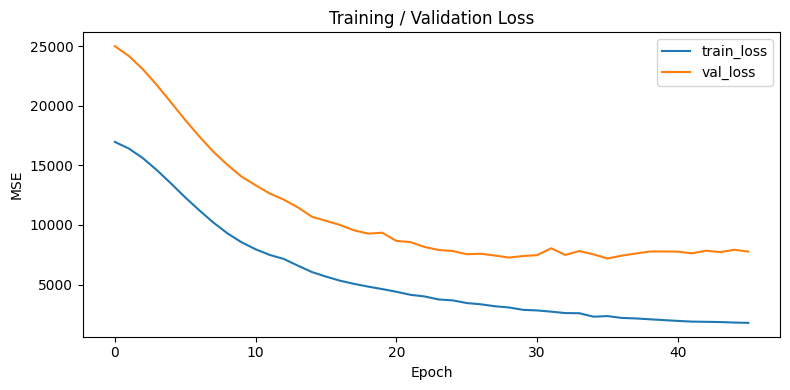

Validation RMSE: 84.78780364990234


,exp,val_rmse,seq_len,batch,epochs
0,main_train,84.787804,48,128,46


In [11]:

os.makedirs('models', exist_ok=True)
results = []

if X_train.size:
    EPOCHS = 80
    BATCH = 128
    model = build_model((X_train.shape[1], X_train.shape[2]), conv_filters=32, lstm_units=128, dropout=0.3)
    model.compile(optimizer=keras.optimizers.Adam(3e-4), loss='mse', metrics=[keras.metrics.RootMeanSquaredError()])

    ckpt_path = 'models/best_model.h5'
    cp = callbacks.ModelCheckpoint(ckpt_path, monitor='val_root_mean_squared_error', save_best_only=True, mode='min', verbose=1)
    es = callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=10, restore_best_weights=True, mode='min', verbose=1)
    rl = callbacks.ReduceLROnPlateau(monitor='val_root_mean_squared_error', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=EPOCHS, batch_size=BATCH, callbacks=[cp, es, rl], verbose=2)

    # Save loss curve
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend(); plt.title('Training / Validation Loss')
    plt.tight_layout()
    plt.savefig('figures/loss_curve.png', dpi=150)
    plt.show()

    # Evaluate on validation set using best weights
    best_rmse = model.evaluate(X_val, y_val, verbose=0)[1]
    print('Validation RMSE:', best_rmse)
    results.append({'exp':'main_train', 'val_rmse': float(best_rmse), 'seq_len': X_train.shape[1], 'batch': BATCH, 'epochs': len(history.history['loss'])})

# Save experiment results CSV
if results:
    df_res = pd.DataFrame(results)
    df_res.to_csv('experiment_results.csv', index=False)
    display(df_res)
else:
    print('No results to save.')


## 9 — Save environment requirements

Export minimal requirements to `requirements.txt` for reproducibility.

In [12]:

# Save a minimal requirements file using pip freeze (works if packages installed in environment)
try:
    get_ipython().system('pip freeze > requirements_full.txt')
    # reduce to important packages (filter)
    keep = []
    with open('requirements_full.txt') as f:
        for ln in f:
            if any(k in ln.lower() for k in ['tensorflow','numpy','pandas','scikit-learn','matplotlib']):
                keep.append(ln)
    with open('requirements.txt','w') as f:
        f.writelines(keep)
    print('requirements.txt saved.')
except Exception as e:
    print('Could not save requirements automatically:', e)


requirements.txt saved.


## 10 — Prediction & submission

Use the trained model to generate predictions on the test set, inverse-scale the outputs if necessary, and save `submission.csv` matching the sample format.

In [13]:

if not test_p.empty and os.path.exists('models/best_model.h5'):
    # Build test sequences using the same features & scaler and keep timestamps for alignment
    features = [c for c in train_p.columns if c != 'pm2.5'][:12]
    SEQ_LEN = X_train.shape[1]

    # ensure datetime index on test_p
    if 'datetime' in test_p.columns:
        test_p = test_p.set_index('datetime').sort_index()

    arr = test_p[features].values  # keep original order (do not drop rows)
    X_list = []
    target_idx = []  # timestamps corresponding to each prediction
    for i in range(SEQ_LEN, len(arr)):
        X_list.append(arr[i-SEQ_LEN:i, :])
        target_idx.append(test_p.index[i])  # prediction corresponds to row at time i

    if len(X_list) == 0:
        print("Not enough test rows to build any sequences (SEQ_LEN too large).")
    else:
        X_test = np.array(X_list)
        # apply scaler if available (scaler fitted on train features)
        if scaler is not None:
            n_samples, n_steps, n_feats = X_test.shape
            X_test = scaler.transform(X_test.reshape(-1, n_feats)).reshape(n_samples, n_steps, n_feats)

        print('X_test shape:', X_test.shape)
        model = keras.models.load_model('models/best_model.h5', compile=False)
        preds = model.predict(X_test, verbose=0).flatten()

        # create series indexed by the timestamp of the predicted row
        preds_series = pd.Series(preds, index=pd.to_datetime(target_idx))

        # prepare sample_sub for alignment (support "row ID" or datetime index)
        sub = sample_sub.copy()
        if 'row ID' in sub.columns:
            # map predictions by datetime (ensure same format)
            try:
                sub_idx = pd.to_datetime(sub['row ID'])
                sub['pm2.5'] = sub_idx.map(preds_series)
            except Exception:
                # fallback: align by position for the first len(preds)
                sub['pm2.5'] = np.nan
                sub.loc[:len(preds)-1, 'pm2.5'] = preds
        else:
            # fallback to index alignment: assume sample_sub rows correspond to test times
            sub['pm2.5'] = np.nan
            sub.loc[sub.index[:len(preds)], 'pm2.5'] = preds

        # fill remaining nulls sensibly (forward/backward fill then global median)
        if sub['pm2.5'].isna().any():
            sub['pm2.5'] = sub['pm2.5'].fillna(method='ffill').fillna(method='bfill')
            if sub['pm2.5'].isna().any():
                fill_val = float(preds_series.median()) if not preds_series.empty else 0.0
                sub['pm2.5'] = sub['pm2.5'].fillna(fill_val)

        sub.to_csv('submission.csv', index=False)
        print('Saved submission.csv (aligned to timestamps, nulls filled).')
else:
    print('Test set or model not available — skipping prediction step.')


X_test shape: (13100, 48, 12)
Saved submission.csv (aligned to timestamps, nulls filled).


C:\Users\HP\AppData\Local\Temp\ipykernel_24012\716481101.py:51: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sub['pm2.5'] = sub['pm2.5'].fillna(method='ffill').fillna(method='bfill')
